In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import cv2



In [2]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hri*.fits"))

In [54]:
len(eui_files)

360

In [57]:
eui_map_all = sunpy.map.Map(eui_files[21::40], sequence=True, memmap=True)
eui_centers = [m.center for m in eui_map_all]

<sunpy.map.mapsequence.MapSequence object at 0x7f0887138f50>
MapSequence of 2 elements, with maps from EUIMap
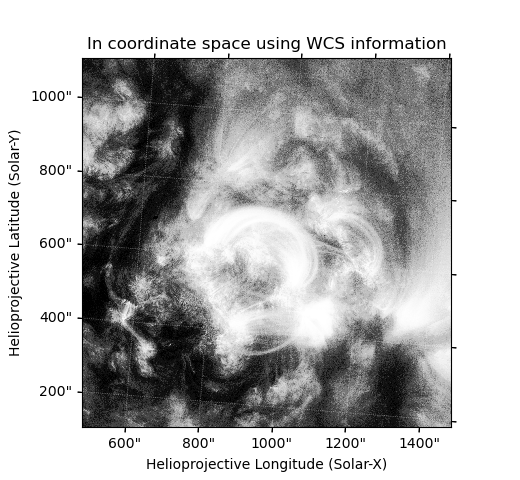
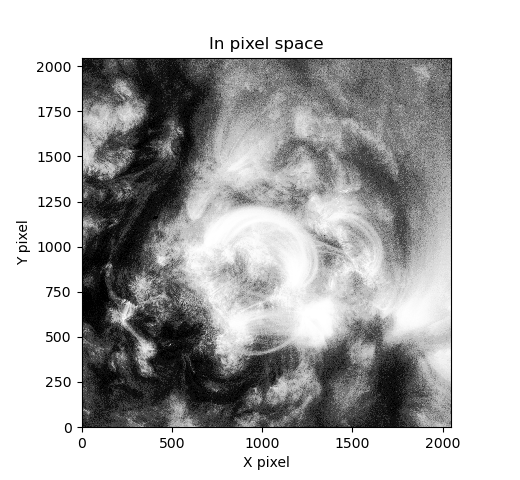
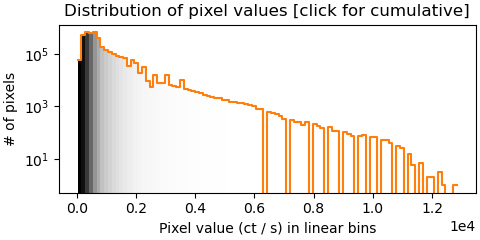
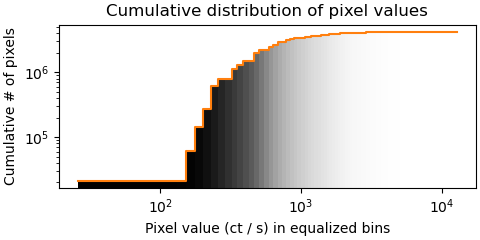
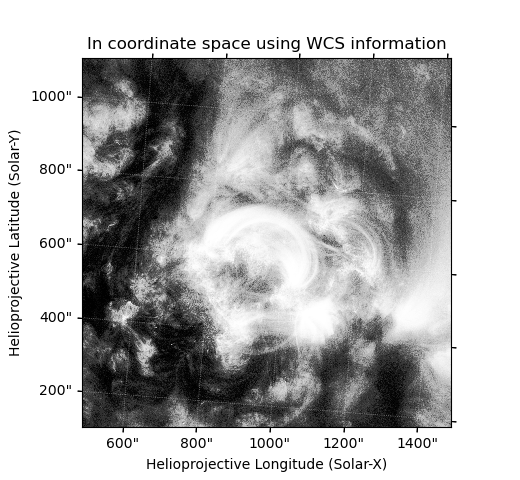
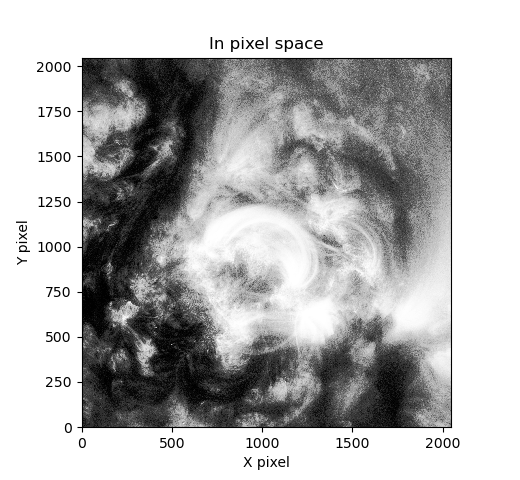
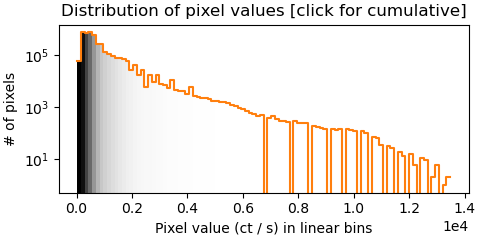
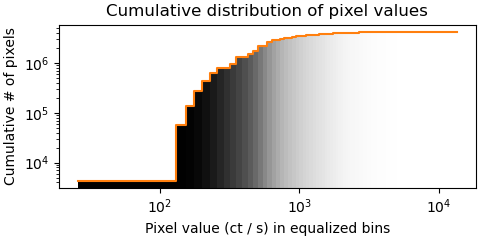

In [61]:
sunpy.map.Map([eui_map_all[0], eui_map_all[-1]], sequence=True)

<sunpy.map.mapsequence.MapSequence object at 0x7f087ce20ed0>
MapSequence of 9 elements, with maps from EUIMap
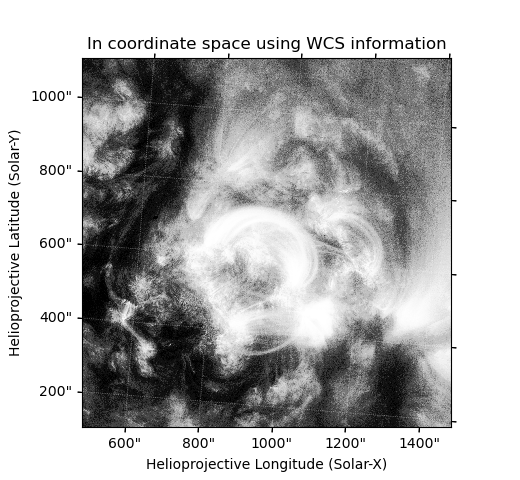
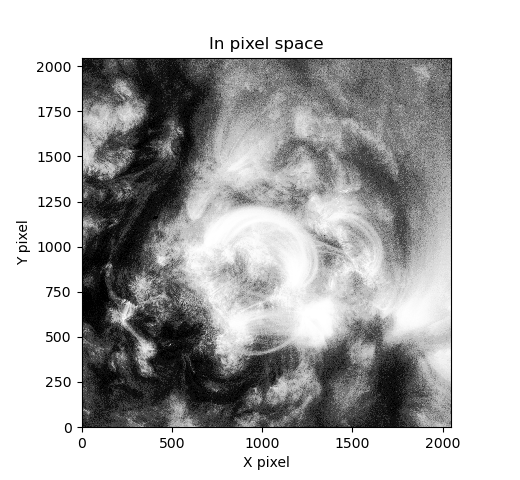
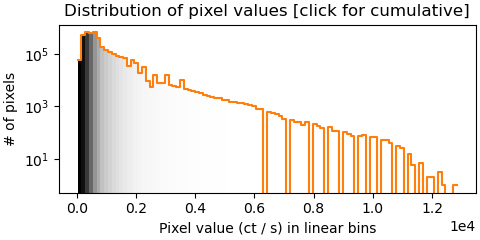
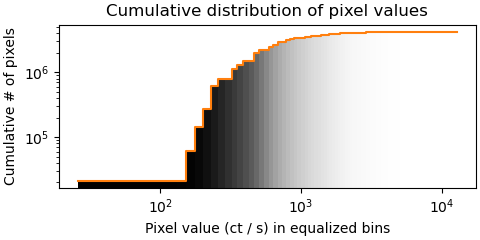
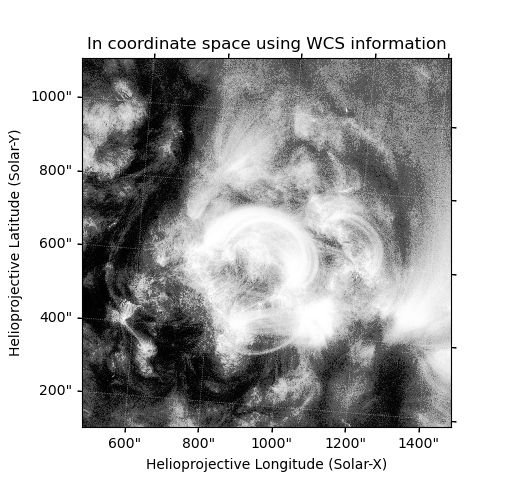
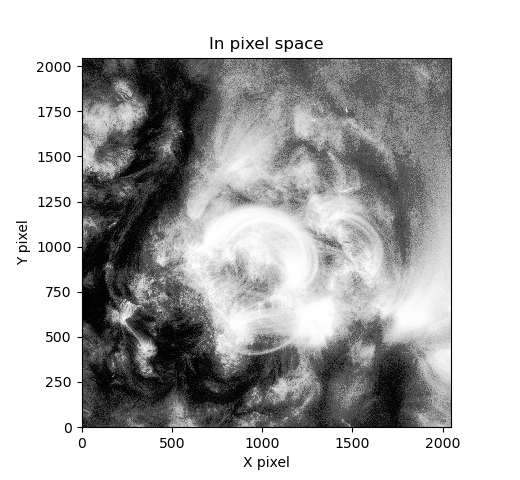
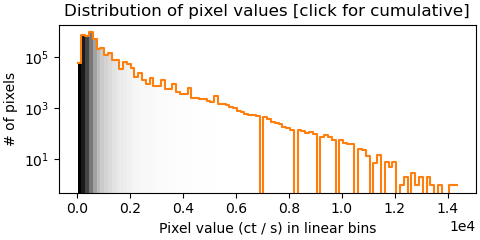
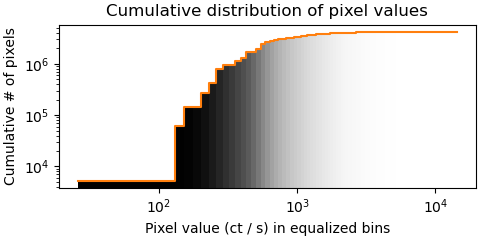
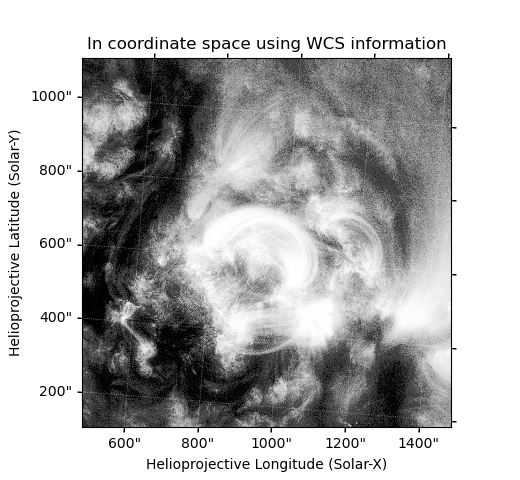
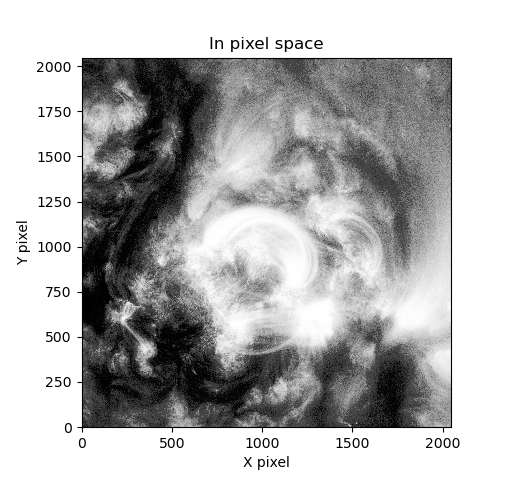
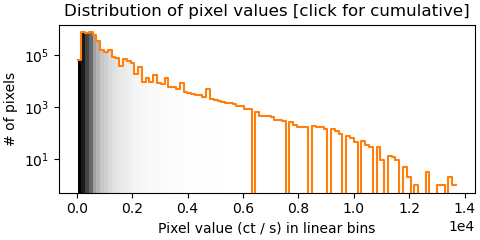
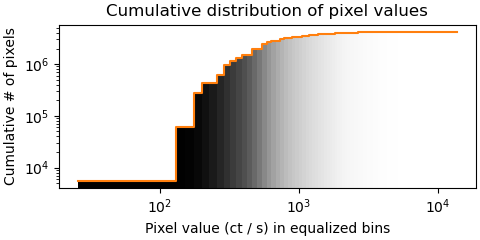
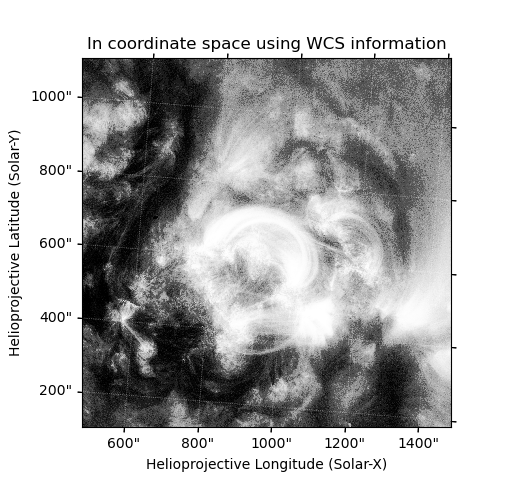
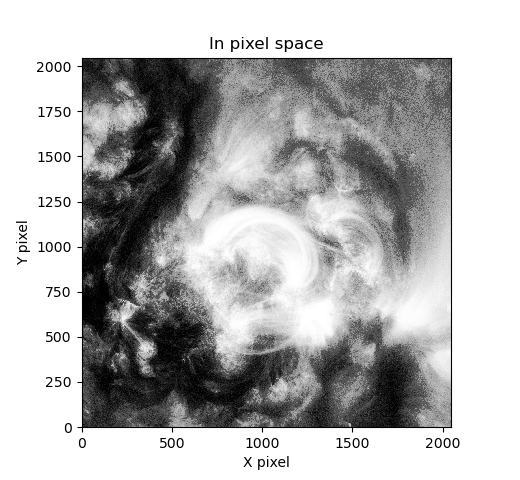
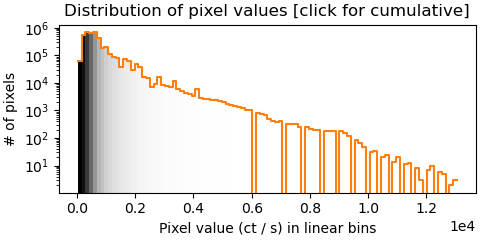
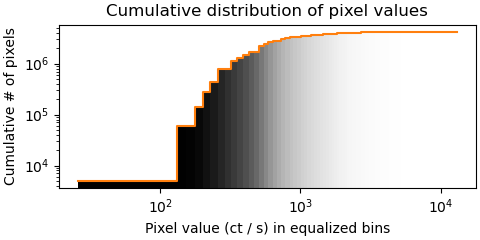
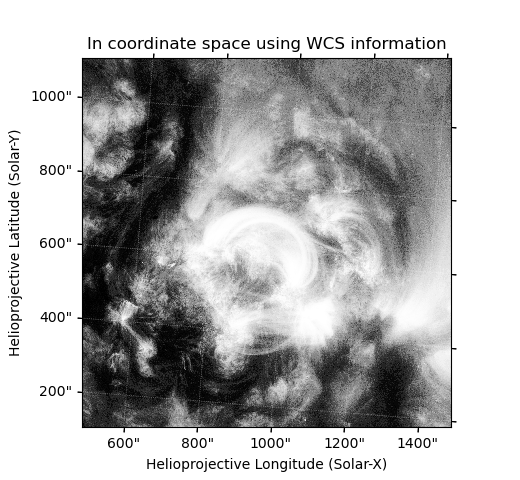
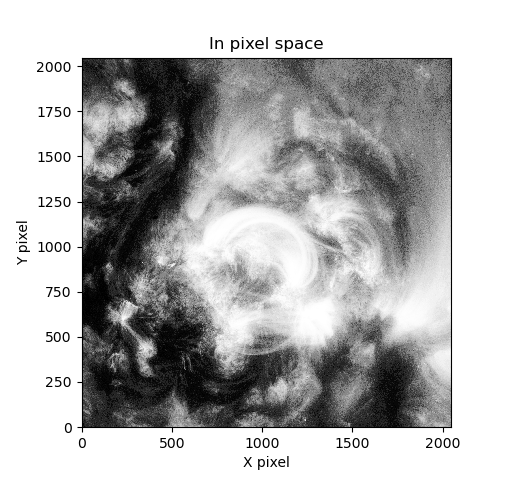
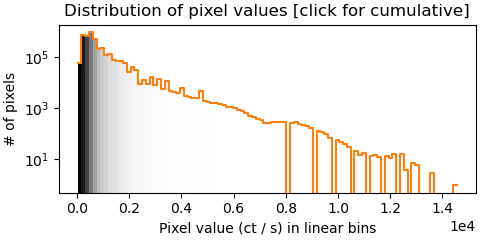
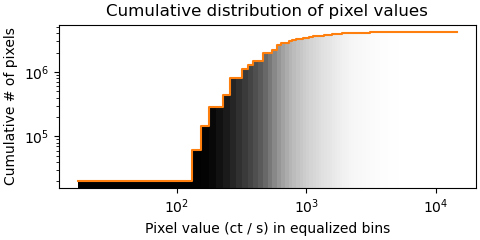
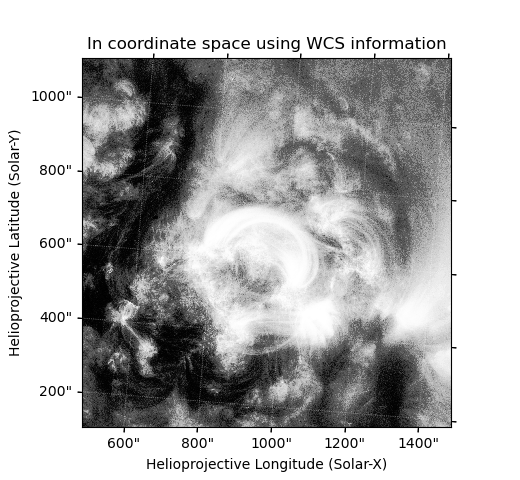
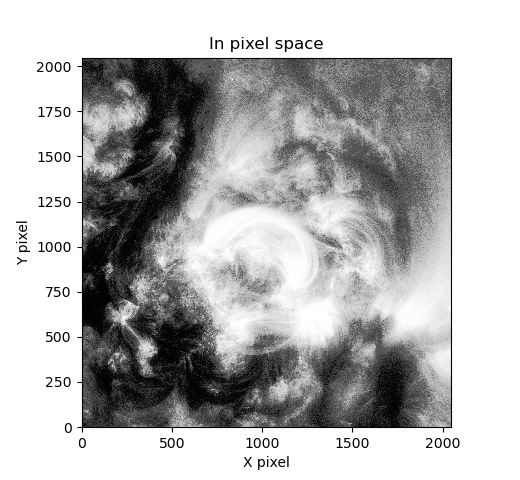
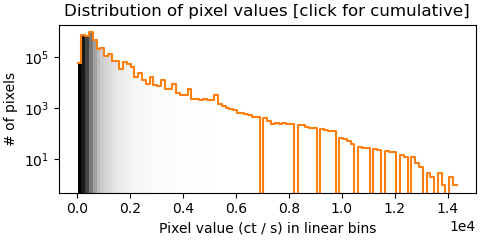
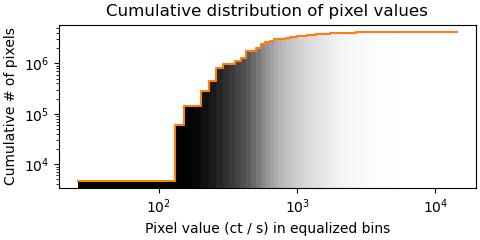
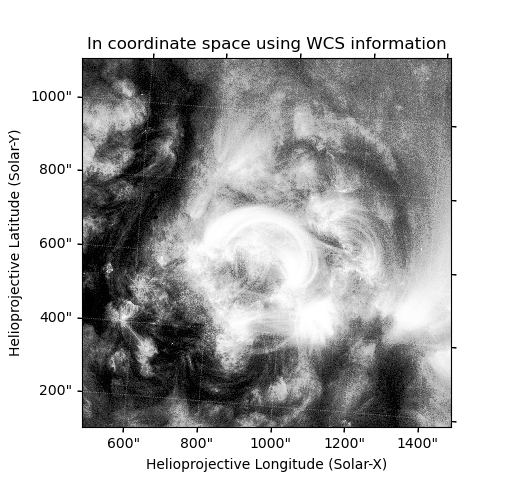
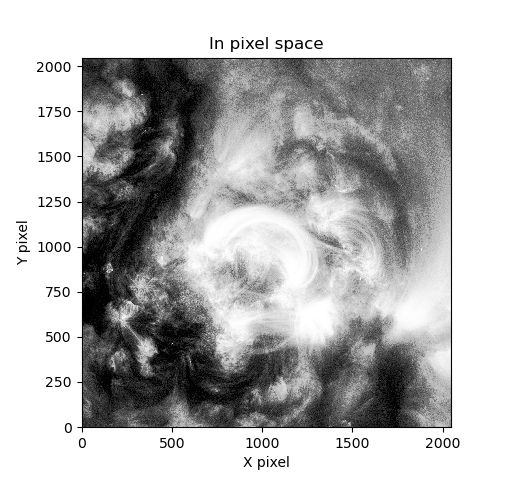
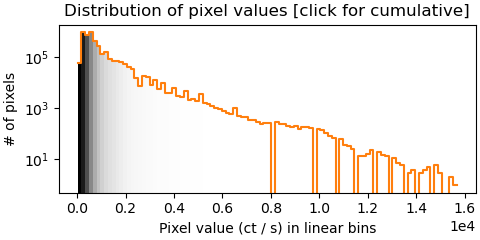
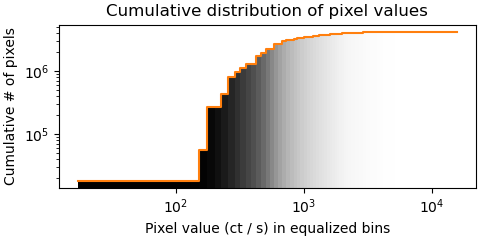
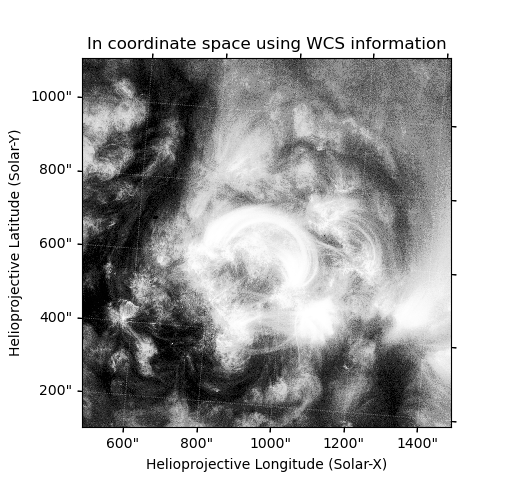
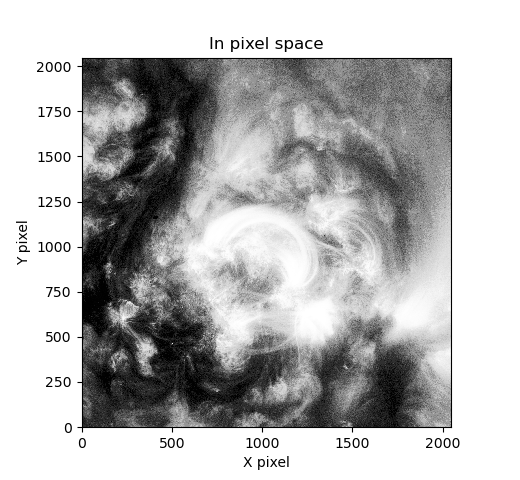
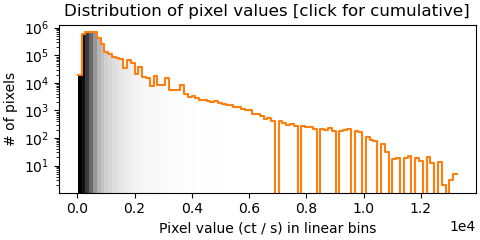
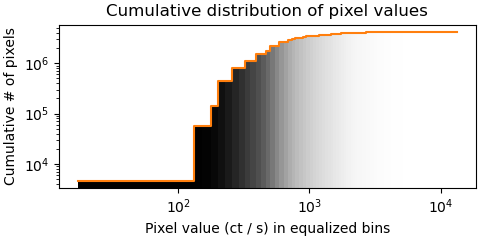
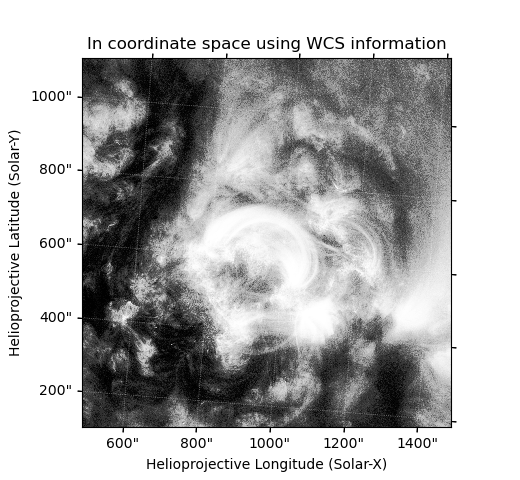
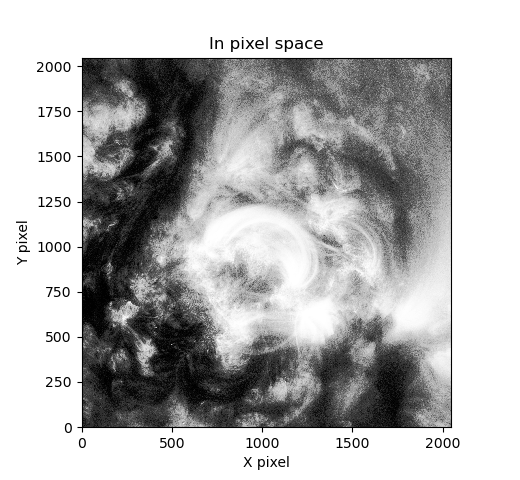
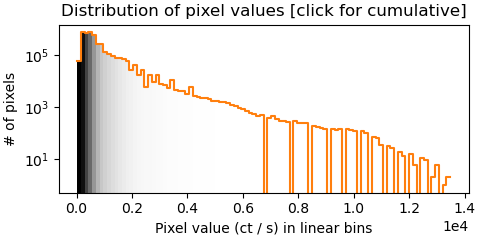
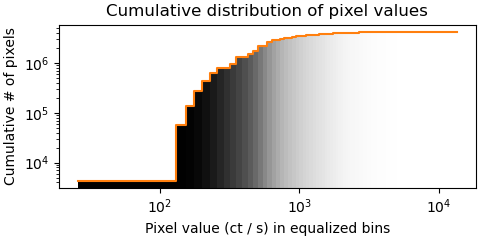

In [58]:
eui_map_all

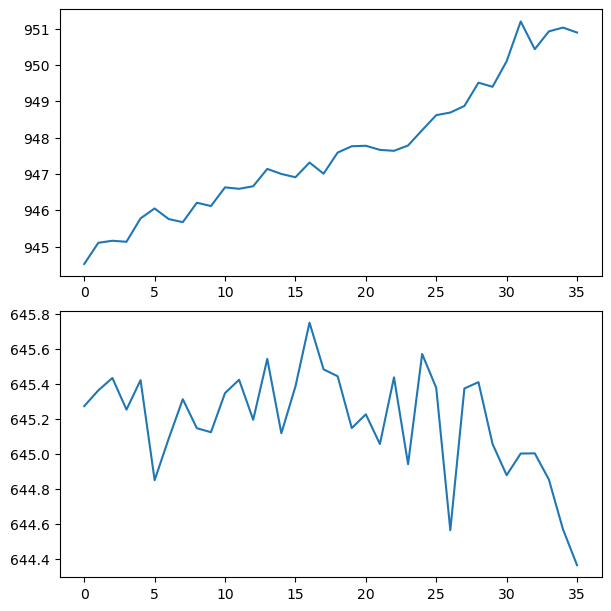

In [44]:
fig, ax = plt.subplots(2,1,figsize=(6,6),layout='constrained')
ax[0].plot([eui_center_.Tx.to_value(u.arcsec) for eui_center_ in eui_centers])
ax[1].plot([eui_center_.Ty.to_value(u.arcsec) for eui_center_ in eui_centers])

In [3]:
eui_template = sunpy.map.Map(eui_files[181]).submap([500,500]*u.pix,top_right=[1500,1500]*u.pix)

In [34]:
eui_map_seq = sunpy.map.Map((eui_files[10],eui_files[181],eui_files[-1]),sequence=True)

In [35]:
eui_map_seq_coalign_shifts = coalignment.calculate_match_template_shift(eui_map_seq,layer_index=-1)

In [6]:
eui_map_seq_coalign_rotation_shifts = coalignment.calculate_solar_rotate_shift(eui_map_seq[:],layer_index=-1)

In [7]:
eui_map_seq_coalign_rotation_shifts

{'x': <Quantity [7.56377404e-02, 2.46325736e-01, 2.16004992e-12] arcsec>,
 'y': <Quantity [7.73132377e-01, 1.28867266e+00, 3.41060513e-13] arcsec>}

In [51]:
eui_map_seq[0].center.Tx, eui_map_seq[0].center.Ty

(<Longitude 945.10374262 arcsec>, <Latitude 645.36163373 arcsec>)

In [52]:
solar_rotate_coordinate(eui_map_seq[0].center, observer=eui_map_seq[-1].observer_coordinate).Tx, solar_rotate_coordinate(eui_map_seq[0].center, observer=eui_map_seq[-1].observer_coordinate).Ty

(<Longitude 951.64562663 arcsec>, <Latitude 644.99848533 arcsec>)

In [8]:
eui_map_seq[0].center

<SkyCoord (Helioprojective: obstime=2022-10-24T19:00:51.014, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-24T19:00:51.014, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-51.38679956, 6.40056454, 5.87671448e+10)>): (Tx, Ty) in arcsec
    (945.10374262, 645.36163373)>

In [28]:
eui_map_seq[1].center

<SkyCoord (Helioprojective: obstime=2022-10-24T19:15:05.997, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-24T19:15:05.997, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-51.35426208, 6.40410934, 5.87866186e+10)>): (Tx, Ty) in arcsec
    (948.48249423, 645.69876877)>

In [29]:
eui_map_seq[-1].center

<SkyCoord (Helioprojective: obstime=2022-10-24T19:29:55.999, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-24T19:29:55.999, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-51.32042118, 6.40779315, 5.88068941e+10)>): (Tx, Ty) in arcsec
    (951.56998889, 644.22535295)>

In [10]:
eui_map_seq_coalign_shifts

{'x': <Quantity [ 0.06474483, -0.32153256,  0.        ] arcsec>,
 'y': <Quantity [-0.06540848, -0.99928043,  0.        ] arcsec>}

In [11]:
eui_map_seq_coalign_shifts_x = eui_map_seq_coalign_shifts["x"].value
eui_map_seq_coalign_shifts_y = eui_map_seq_coalign_shifts["y"].value

In [20]:
eui_map_seq_coalign = coalignment.mapsequence_coalign_by_match_template(eui_map_seq,shift=eui_map_seq_coalign_rotation_shifts)

In [21]:
Txshift_hri, Tyshift_hri = (1.67083 + 1.40322)*u.arcsec,(7.60192 - 2.32321 )*u.arcsec
# eui_map_seq_coalign_shift = eui_map_seq_coalign.shift_reference_coord(Txshift_hri,Tyshift_hri)

In [22]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")

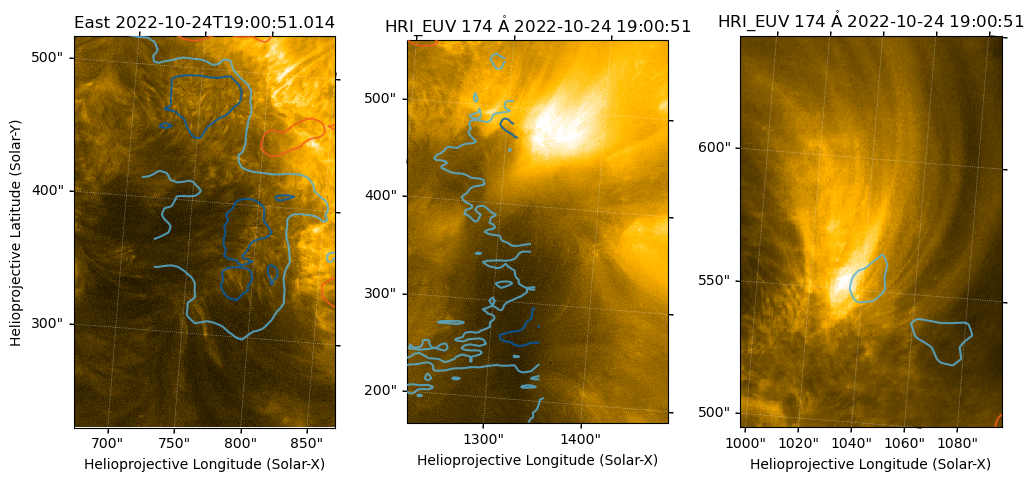

In [53]:

map = eui_map_seq_coalign[0].shift_reference_coord(Txshift_hri,Tyshift_hri)
eui_map_region_east = map.submap([400,200]*u.pix,top_right=[800,800]*u.pix)
eui_map_region_west = map.submap([1500,0]*u.pix,top_right=[2048,800]*u.pix)
eui_map_region_center = map.submap([1100,700]*u.pix,top_right=[1300,1000]*u.pix)

fig = plt.figure(figsize=(10,7),constrained_layout=True)
ax1 = fig.add_subplot(1,3,1,projection=eui_map_region_east)
ax2 = fig.add_subplot(1,3,2,projection=eui_map_region_west)
ax3 = fig.add_subplot(1,3,3,projection=eui_map_region_center)

eui_map_region_east.plot(axes=ax1,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.1)))
eui_map_region_west.plot(axes=ax2,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.1)))
eui_map_region_center.plot(axes=ax3,norm=ImageNormalize(vmin=10,vmax=1e4,stretch=AsinhStretch(0.3)))

ax1.set_title(f"East {map.date}")

ax2.set_ylabel(" ")
ax3.set_ylabel(" ")

for ax_ in (ax1,ax2,ax3):
    bounds = ax_.axis()
    with propagate_with_solar_surface():
        eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                            axes=ax_)
    ax_.axis(bounds)
# fig.clf()
# plt.colorbar(ax1.images[0],ax=ax1)

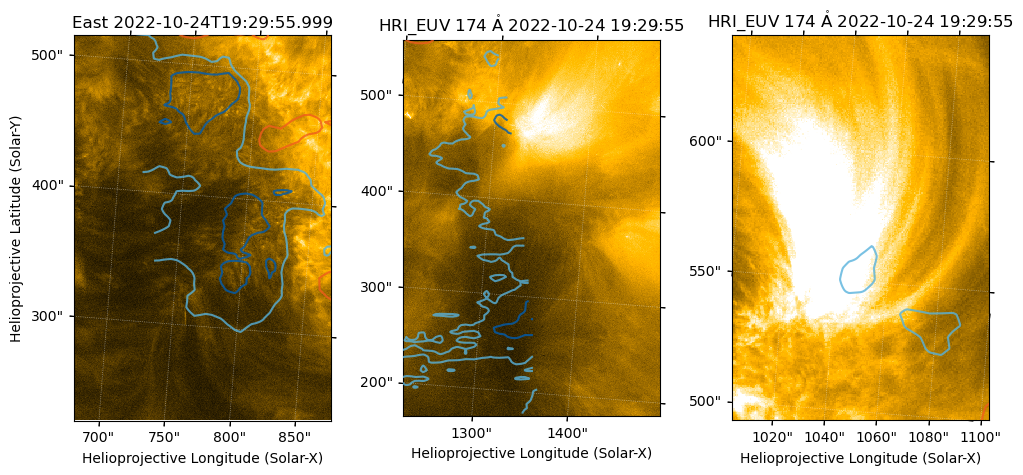

In [24]:
map = eui_map_seq_coalign[-1].shift_reference_coord(Txshift_hri,Tyshift_hri)
eui_map_region_east = map.submap([400,200]*u.pix,top_right=[800,800]*u.pix)
eui_map_region_west = map.submap([1500,0]*u.pix,top_right=[2048,800]*u.pix)
eui_map_region_center = map.submap([1100,700]*u.pix,top_right=[1300,1000]*u.pix)

fig = plt.figure(figsize=(10,7),constrained_layout=True)
ax1 = fig.add_subplot(1,3,1,projection=eui_map_region_east)
ax2 = fig.add_subplot(1,3,2,projection=eui_map_region_west)
ax3 = fig.add_subplot(1,3,3,projection=eui_map_region_center)

eui_map_region_east.plot(axes=ax1,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.1)))
eui_map_region_west.plot(axes=ax2,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.1)))
eui_map_region_center.plot(axes=ax3,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.3)))

ax1.set_title(f"East {map.date}")

ax2.set_ylabel(" ")
ax3.set_ylabel(" ")

for ax_ in (ax1,ax2,ax3):
    bounds = ax_.axis()
    with propagate_with_solar_surface():
        eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                            axes=ax_)
    ax_.axis(bounds)
# fig.clf()
# plt.colorbar(ax1.images[0],ax=ax1)

In [64]:
eui_map_seq_coalign[-1].date

<Time object: scale='utc' format='isot' value=2022-10-24T19:29:55.999>

In [49]:
laplcian_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
sharpen_weight = 1
eui_map_region_east_data_sharp = (1 + sharpen_weight)*eui_map_region_east.data - sharpen_weight*cv2.GaussianBlur(eui_map_region_east.data,(5,5),cv2.BORDER_DEFAULT)
eui_map_region_east_sharp = sunpy.map.Map(eui_map_region_east_data_sharp,eui_map_region_east.meta)

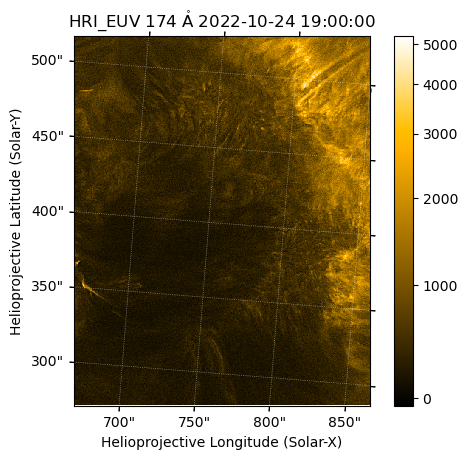

In [50]:
eui_map_region_east_sharp.plot_settings["norm"] = ImageNormalize(stretch=AsinhStretch(0.3))
eui_map_region_east_sharp.plot()
plt.colorbar()

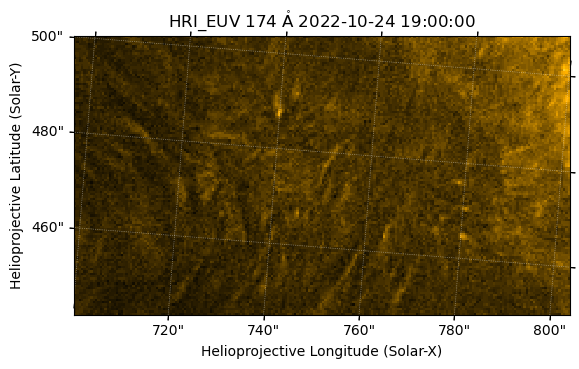

In [55]:
eui_map_region_east_zoomin_1 = eui_map_region_east_sharp.submap(SkyCoord(700*u.arcsec,450*u.arcsec,frame=eui_map_region_east.coordinate_frame),
                                                        top_right=SkyCoord(800*u.arcsec,500*u.arcsec,frame=eui_map_region_east.coordinate_frame))
eui_map_region_east_zoomin_1.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=5000,stretch=AsinhStretch(0.3))
eui_map_region_east_zoomin_1.plot()